In [55]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [56]:
import os, sys

import experiment_util
import evaluation_util as eva
import evaluation_util
import pandas as pd

from heapq import nsmallest
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import experiment_util as ex2util
from experiment_util import hyper_init_dict
import experiment_models as ex2models

import theano_models as tm
import theano_models.probabilistic_models as pm
from theano.tensor.shared_randomstreams import RandomStreams
from schlichtanders.myobjects import NestedNamespace
from schlichtanders.mydicts import update

import numpy as np

In [57]:
pm.RNG = NestedNamespace(tm.PooledRandomStreams(pool_size=int(1e8)), RandomStreams())

In [58]:
main_folder = os.path.dirname(os.getcwd())

sys.path.append(main_folder)

import experiment1.experiment_util as ex1util
Hypers = ex1util.get_hyper(), ex1util.get_semiold_hyper(), ex1util.get_old_hyper()

# global

In [59]:
Hyper = ex2util.get_hyper()
filepath = os.path.realpath("interactive.db")

In [60]:
datasetnames = ["boston","concrete","energy","powerplant","kin8nm", "winered","yacht"] #, "toy1d","toy2d"]
folders = ["../experiment1/withpercent", '../experiment1/first_useful_hyperparameter_search', '../experiment1/run_windows/']

In [61]:
datasetname = datasetnames[2]
modelname = "planarflow"
optimization_type = "annealing"
print datasetname, modelname, optimization_type

energy planarflow annealing


# get best parameters / hyper

In [62]:
reload(eva)

<module 'evaluation_util' from '/home/stephan/GitProjects/theano_models/experiment2/__file__'>

In [63]:
best_hyper = eva.get_best_hyper_autofix(datasetname, folders, modelnames=[modelname], n_normflows=[[8,20]], test_attrs=["best_val_loss"])
best_hyper = best_hyper[0]

In [64]:
print best_hyper.best_val_loss
print best_hyper.best_val_error
print best_hyper.best_parameters
print best_hyper.n_normflows

2.35238400414
5.65012598038
[-0.11749179 -0.6768476  -1.33690291 ...,  0.43843501 -0.47274211
 -0.29562431]
8


# test runs

In [65]:
data, error_func = ex2util.load_and_preprocess_data(datasetname)
X, Z, VX, VZ, TX, TZ = data

In [66]:
init_dict = {k:v for k, v in best_hyper.__dict__.iteritems() if k[:3] not in ["bas", "pla", "rad", "mix"]}
del init_dict['best_val_loss']
update(init_dict, ex2util.get_init_data(data), overwrite=True)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb7fe7d6790>,
 'adapt_prior': False,
 'annealing_T': None,
 'batch_size': 1,
 'best_epoch': 0,
 'best_parameters': array([-0.11749179, -0.6768476 , -1.33690291, ...,  0.43843501,
        -0.47274211, -0.29562431]),
 'best_test_error': 4.9672441482543945,
 'best_test_loss': 2.641917340167157,
 'best_val_error': 5.650125980377197,
 'datasetname': 'energy',
 'dim': None,
 'errorrate_average_n': 10,
 'example_input': array([ 1.28497386, -1.22923756,  0.        , -1.19867527,  1.        ,
        -0.44721359,  0.11736926,  0.76615393], dtype=float32),
 'example_output': array([ 0.93049884], dtype=float32),
 'exp_average_n': 20,
 'exp_ratio_estimator': u'grouping',
 'init_parameters': array([ 1.64702671,  0.06629987, -1.32451814, ...,  0.48186501,
        -0.35575166, -0.17390877]),
 'logP_average_n': 3,
 'logP_average_n_final': 10,
 'logP_average_n_intermediate': 3,
 'max_epochs_without_improvement': 30,
 'minus_log_s1': 1,
 '

In [67]:
hyper = Hyper(datasetname, modelname, optimization_type="annealing")  #"annealing"
hyper_init_dict(hyper, init_dict)
hyper.annealing_T = 100
hyper.adapt_prior = False
if hyper.adapt_prior:
    hyper.init_parameters = np.r_[hyper.init_parameters, 0]
hyper.max_epochs_without_improvement = 40

if "radial" in modelname:
    hyper.n_normflows = 2*hyper.n_normflows  # compatibility issue

In [68]:
hyper.init_parameters = None
hyper.n_normflows = 20

In [69]:
engine = create_engine('sqlite:///' + filepath)  # os.path.join(__path__, foldername, '%s.db' % filename)
Hyper.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
sql_session = Session()

<IPython.core.display.Javascript object>


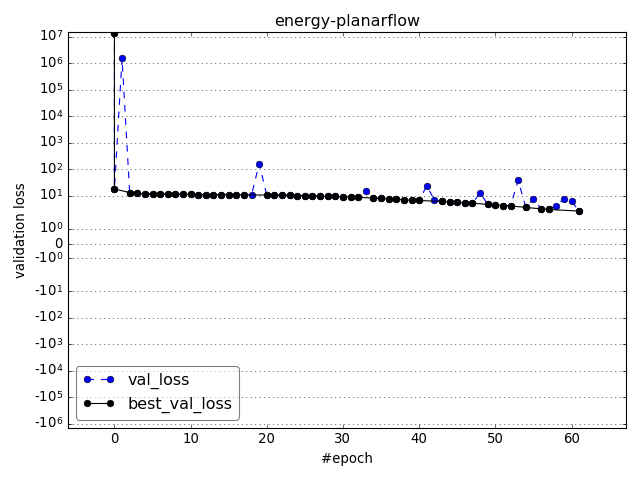

In [ ]:
plt.figure()
h_val = plt.plot([],[], color='blue', linestyle='dashed', marker='o', label="val_loss")[0]
h_best_val = plt.plot([], [], color='black', linestyle='solid', marker='o', label="best_val_loss")[0]
plt.yscale('symlog')
# plt.tick_params(axis='y', which='minor')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.1g"))
# plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
plt.gca().yaxis.grid(True)
plt.ylabel("validation loss")
plt.xlabel("#epoch")
plt.title("%s-%s" % (datasetname, modelname))
plt.legend(loc='lower left', fancybox=True, framealpha=0.5)

In [ ]:
model_creator = getattr(ex2models, modelname)
model, approx_posterior = model_creator(hyper)

ex2util.optimize(data, hyper, model, error_func, plot_val=h_val, plot_best_val=h_best_val)

normalizing flow annealing
new random init_parameters
used given init_parameters
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 

In [ ]:
hyper.best_test_loss

In [ ]:
hyper.best_val_loss

In [ ]:
hyper.best_test_error

In [ ]:
hyper.best_val_error